In [83]:
import numpy as np
import pandas as pd
from surprise import Dataset, Reader
from scipy.spatial import distance
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
ratings = pd.read_csv(r'BX-CSV-Dump/BX-Book-Ratings.csv', delimiter=';', error_bad_lines=False, encoding='latin-1')
books = pd.read_csv(r'BX-CSV-Dump/BX-Books.csv', delimiter=';', error_bad_lines=False, encoding='latin-1')
users = pd.read_csv(r'BX-CSV-Dump/BX-Users.csv', delimiter=';', error_bad_lines=False, encoding='latin-1')

ratings = ratings.loc[ratings['ISBN'].isin(books['ISBN'])]
ratings = ratings.loc[ratings['Book-Rating']!=0]
ratings = ratings.rename(columns={"User-ID":"User","Book-Rating":"Rating"})

# drop books which have 13-char ISBN
ratings = ratings.loc[ratings['ISBN'].apply(len)==10]

# we want to recommand about book title and not ISBN, for convinience of predicting new user
ratings.ISBN = ratings.ISBN.astype(str)
books.ISBN = books.ISBN.astype(str)
ratings = ratings.merge(books[['ISBN','Book-Title']], on='ISBN',how='inner')

b'Skipping line 6452: expected 8 fields, saw 9\nSkipping line 43667: expected 8 fields, saw 10\nSkipping line 51751: expected 8 fields, saw 9\n'
b'Skipping line 92038: expected 8 fields, saw 9\nSkipping line 104319: expected 8 fields, saw 9\nSkipping line 121768: expected 8 fields, saw 9\n'
b'Skipping line 144058: expected 8 fields, saw 9\nSkipping line 150789: expected 8 fields, saw 9\nSkipping line 157128: expected 8 fields, saw 9\nSkipping line 180189: expected 8 fields, saw 9\nSkipping line 185738: expected 8 fields, saw 9\n'
b'Skipping line 209388: expected 8 fields, saw 9\nSkipping line 220626: expected 8 fields, saw 9\nSkipping line 227933: expected 8 fields, saw 11\nSkipping line 228957: expected 8 fields, saw 10\nSkipping line 245933: expected 8 fields, saw 9\nSkipping line 251296: expected 8 fields, saw 9\nSkipping line 259941: expected 8 fields, saw 9\nSkipping line 261529: expected 8 fields, saw 9\n'
C:\Users\yuvalf\AppData\Local\Continuum\anaconda3\lib\site-packages\IPytho

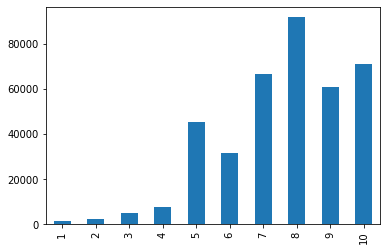

In [3]:
ratings['Rating'].value_counts().sort_index().plot(kind="bar")

In [4]:
poc_df = ratings.sample(n=100000,random_state=123)

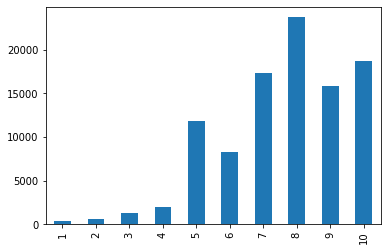

In [158]:
poc_df['Rating'].value_counts().sort_index().plot(kind="bar")

In [5]:
from surprise import KNNWithMeans, KNNBasic

# To use user-based cosine similarity
sim_options = {
    "name": "cosine",
    "user_based": True,  # Compute similarities between users
}

algo = KNNBasic(sim_options=sim_options, k=10)

In [6]:
reader = Reader(rating_scale=(1, 10))
data = Dataset.load_from_df(poc_df[["User", "Book-Title", "Rating"]], reader)

training = data.build_full_trainset()

algo.fit(training)

# Computing the cosine similarity matrix...
# Done computing similarity matrix.
# <surprise.prediction_algorithms.knns.KNNWithMeans object at 0x7f04fec56898>



Computing the cosine similarity matrix...
Done computing similarity matrix.


In [7]:
f = lambda book: algo.predict(uid=np.random.choice(poc_df['User']),iid=book).est
res = pd.Series(poc_df['Book-Title'].unique()).apply(f)

In [12]:
df_res = pd.DataFrame(np.column_stack((poc_df['Book-Title'].unique(),res)), columns=["title","score"])
df_res['score'] = df_res['score'].astype(float)
df_res

,title,score
0,Affairs of State,7.63385
1,Dark Between the Stars,7.63385
2,The Ballad of Frankie Silver,7.63385
3,Patton: The Man Behind the Legend 1885 1945,7.63385
4,The Hobbit : The Enchanting Prelude to The Lor...,7.63385
...,...,...
53035,Ki Te Ao: New Stories,7.63385
53036,The Rugrats Movie Storybook,10.00000
53037,Glare Ice: A Claire Watkins Mystery (Claire Wa...,9.00000
53038,The Immortal Highlander,7.63385


In [28]:
# we want to get the new user and compute dists
# therfore we need his books
books = np.random.choice(poc_df['Book-Title'],size=np.random.randint(10))
rates = np.random.choice(np.arange(1,11),size=len(books),p=np.arange(1,11)/np.sum(np.arange(1,11)))
# symmulation of what we get from Eitan's function
new_data = dict(zip(books,rates))

In [29]:
new_data

{'Enthusiasm: A Chapter in the History of Religion : With Special Reference to the XVII and XVIII Centuries': 8,
 'Tara Road': 4,
 'Daughter of God': 2,
 'Basket Case': 8,
 'The Awakening : A Vampire Huntress Legend (Vampire Huntress Legend)': 9,
 "Murder on a Girls' Night Out: A Southern Sisters Mystery": 10,
 'Star fire': 9,
 'Deadeye Dick': 7}

In [266]:
# reduce df to only relevant books for that new user
# poc_df.loc[poc_df['Book-Title'].isin(books)]

In [30]:
# according to vidhya tutorial NaN --> 0
user_item = pd.pivot(poc_df.loc[poc_df['Book-Title'].isin(books)],index='User',columns='Book-Title',values='Rating')
# user_item = user_item.fillna(0)

In [69]:
merged = user_item.append(pd.Series(new_data,name="new")).apply(lambda x: x-4.5).fillna(0)
merged

Book-Title,Basket Case,Daughter of God,Deadeye Dick,Enthusiasm: A Chapter in the History of Religion : With Special Reference to the XVII and XVIII Centuries,Murder on a Girls' Night Out: A Southern Sisters Mystery,Star fire,Tara Road,The Awakening : A Vampire Huntress Legend (Vampire Huntress Legend)
User,,,,,,,,
15692,0.0,0.0,0.0,0.0,0.0,0.0,4.5,0.0
21188,0.0,0.0,0.0,0.0,0.0,0.0,5.5,0.0
22095,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0
24921,0.0,0.0,0.0,0.0,0.0,0.0,3.5,0.0
29907,0.0,0.0,0.0,0.0,0.0,0.0,2.5,0.0
...,...,...,...,...,...,...,...,...
259542,2.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0
265889,0.0,0.0,0.0,0.0,3.5,0.0,0.0,0.0
274301,0.0,0.0,0.0,0.0,0.0,0.0,5.5,0.0


In [88]:
# distance.cosine(merged.loc[276688].fillna(0), merged.loc['new'])
vf = np.vectorize(lambda user: 1-distance.cosine(merged.loc[user], merged.loc['new']))
user_itemvf(merged.index.values[:-1])

array([-0.04811252, -0.04811252, -0.04811252, -0.04811252, -0.04811252,
       -0.04811252,  0.33678766,  0.33678766,  0.24056261,  0.33678766,
        0.24056261, -0.04811252,  0.24056261, -0.04811252,  0.24056261,
       -0.04811252, -0.04811252, -0.04811252,  0.33678766, -0.04811252,
        0.4330127 , -0.04811252, -0.04811252,  0.52923775, -0.04811252,
       -0.24056261, -0.04811252, -0.04811252,  0.33678766, -0.04811252,
       -0.04811252, -0.33678766,  0.33678766,  0.24056261, -0.04811252,
        0.33678766, -0.04811252, -0.04811252,  0.52923775, -0.04811252,
       -0.04811252, -0.04811252,  0.33678766,  0.33678766,  0.33678766,
       -0.24056261,  0.33678766,  0.33678766, -0.04811252, -0.04811252,
       -0.04811252, -0.24056261,  0.33678766,  0.33678766, -0.04811252,
       -0.04811252,  0.33678766, -0.4330127 , -0.04811252,  0.24056261,
       -0.24056261, -0.04811252,  0.33678766,  0.52923775, -0.04811252,
        0.33678766])

In [84]:
cosine_similarity(merged)

array([[ 1.        ,  1.        ,  1.        , ...,  1.        ,
         0.        , -0.04811252],
       [ 1.        ,  1.        ,  1.        , ...,  1.        ,
         0.        , -0.04811252],
       [ 1.        ,  1.        ,  1.        , ...,  1.        ,
         0.        , -0.04811252],
       ...,
       [ 1.        ,  1.        ,  1.        , ...,  1.        ,
         0.        , -0.04811252],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         1.        ,  0.33678766],
       [-0.04811252, -0.04811252, -0.04811252, ..., -0.04811252,
         0.33678766,  1.        ]])

In [290]:
# def get_user_recs():
#     recoms_list = {}
#     #getting 1st recomendation
#     title = input('please enter a title of a book you would like to rate:  ')
#     while not(any(ratings['Book-Title'] == title)):
#          title = input('sorry the book you chose is not in our data base \n please enter a title of another book you would like to rate')
#     rating = input('please rate the book you entered:  ')
#     recoms_list[title] = rating
#     # getting more recomendations
#     while len(recoms_list) <= 10:
#         title = input('please enter a title of a book you would like to rate: \n or to continue type "stop" :')
#         #if we have a stop
#         if title == 'stop':
#             return(recoms_list)
#         else:
#             while not(any(ratings['Book-Title'] == title)):
#                 title = input('sorry the book you chose is not in our data base \n please enter a title of another book you would like to rate')
#             rating = input('please rate the book you entered:  ')
#             recoms_list[title] = rating
#     print("thanks, you gave us anough books to work with")
#     return(recoms_list)